In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

In [2]:
dt_labels = pd.read_csv('./Dataset/Labels.csv')
print(dt_labels.head())
print(dt_labels.shape)

                image  label
0  Img/img001-001.png      0
1  Img/img001-002.png      0
2  Img/img001-003.png      0
3  Img/img001-004.png      0
4  Img/img001-005.png      0
(550, 2)


In [72]:
image_paths = dt_labels['image']
images = []
for filename in os.listdir("./Dataset/Img"):
    img = cv2.imread(os.path.join("./Dataset/Img",filename), 0)
    if img is not None:
        images.append(img)
print("Loaded all images!")
train_X = np.array(images)
train_X = train_X.reshape(550, 900 * 1200)
train_X = train_X.transpose()
train_X = tf.math.divide(train_X, 255)
train_X = tf.math.subtract(train_X, 1)
print(train_X.shape)
print("All the training set it's ready")

Loaded all images!
(1080000, 550)
All the training set it's ready


In [4]:
train_Y = tf.one_hot(dt_labels['label'], 9)
train_Y = tf.transpose(train_Y)
print(train_Y)

tf.Tensor(
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(9, 550), dtype=float32)


In [24]:
def initialize_parameters():
    # My model will have tree layers of 13 (Features layer), 5 Units, 3 Units and the Output Layer with 1 Unit
    # I will use Tensorflow Keras initializers to do this
    
    # And... I'll use the He initialization because i have Relu activations in my model
    initializerHe = tf.keras.initializers.HeNormal(seed=1)
    
    # And a Glotot Normal to the output layer (Sigmoid)
    initializerGn = tf.keras.initializers.GlorotNormal(seed=1)
    
    W1 = tf.Variable(initializerHe(shape=(5, 1080000)))
    b1 = tf.Variable(initializerHe(shape=(5, 1)))
    W2 = tf.Variable(initializerHe(shape=(3, 5)))
    b2 = tf.Variable(initializerHe(shape=(3, 1)))
    W3 = tf.Variable(initializerGn(shape=(9, 3)))
    b3 = tf.Variable(initializerGn(shape=(9, 1)))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [25]:
parameters = initialize_parameters()

In [26]:
def forward_propagation(X, parameters):
    # Retrieve the parameters
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Activations...
    
    Z1 = tf.math.add(tf.linalg.matmul(W1,X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2,A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3,A2), b3)
    A3 = tf.keras.activations.softmax(Z3)
    
    return Z3

In [28]:
print(forward_propagation(train_X, parameters))

tf.Tensor(
[[  56.517406     60.26123      10.9505     ...   52.45413
   112.49237     170.0737    ]
 [-136.43404     -93.60951    -133.40567    ... -136.0949
  -134.86037    -134.16492   ]
 [  13.774576      4.564145     23.719105   ...   14.647883
     0.5270375    -5.02413   ]
 ...
 [  21.554043     24.737474      0.52229965 ...   19.68094
    47.56858      76.28488   ]
 [ 120.70548     115.862        49.87823    ...  114.37259
   206.40013     310.54507   ]
 [ 117.53891      75.397835    125.591095   ...  118.19039
   102.54964      90.18326   ]], shape=(9, 550), dtype=float32)


In [73]:
def compute_cost(predicted_Y, true_Y):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    return cce(true_Y, predicted_Y)

In [38]:
pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
true = tf.constant([[ 1,   0 ],
             [1,  1 ],
             [ 0,  0],
             [ 0,    0 ],
             [ 1,    1 ],
             [ 1,   0  ]])
print(compute_cost(pred, true))

tf.Tensor(1.8070068, shape=(), dtype=float32)


In [49]:
def model(X_train, Y_train, learning_rate = 0.0001, num_epochs = 1500, print_cost = True):
    
    # Save all the costs around the training
    costs = []
    
    # Initialize the parameters
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # I want to use the Adam optimizer in my model, in my experience, it's very efficient
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            # Do the fordward propagation
            Z3 = forward_propagation(X_train, parameters)

            # Compute the cost function
            cost = compute_cost(Z3, Y_train)

        trainable_variables = [W1, b1, W2, b2, W3, b3]
        grads = tape.gradient(cost, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))

        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, cost))

        costs.append(cost)
    
    return parameters, costs

Cost after epoch 0: 4973.677246
Cost after epoch 10: 5069.569336
Cost after epoch 20: 5539.490234
Cost after epoch 30: 5948.379395
Cost after epoch 40: 6382.732422
Cost after epoch 50: 6838.547363
Cost after epoch 60: 7279.053223
Cost after epoch 70: 7814.289062
Cost after epoch 80: 8388.155273
Cost after epoch 90: 9247.856445


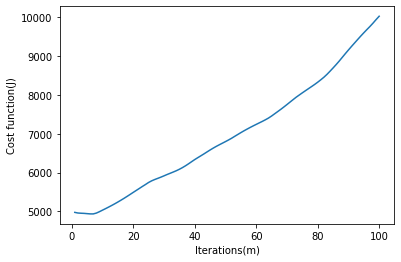

In [75]:
num_epochsTrain = 100
parameters, costs = model(train_X, train_Y, learning_rate = 0.0001,num_epochs = num_epochsTrain)
plt.plot(np.arange(num_epochsTrain)+1, costs)
plt.xlabel("Iterations(m)")
plt.ylabel("Cost function(J)")
plt.show()

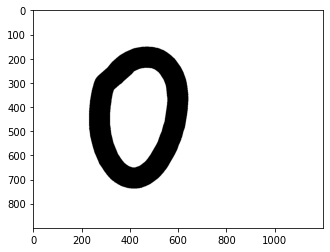

In [34]:
temp4 = train_X[:,0]
temp4 = tf.reshape(temp4,(900, 1200))
plt.gray()
plt.imshow(temp4)

tf.Tensor(
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.

TypeError: Invalid shape (900,) for image data

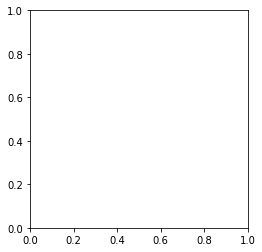

In [77]:
test1 = train_X[:,0]
#print(tf.reshape(test1,(900, 1200)))
print(tf.reshape(test1,(900, 1200))[:,450])
plt.imshow(tf.reshape(test1,(900, 1200))[:,450])
#plt.imshow(tf.reshape(test1,(900, 1200)))
#test1 = tf.reshape(test1,(1080000,1))
#Ztest = forward_propagation(test1, parameters)
#Ztest = tf.keras.activations.softmax(Ztest)
#print(Ztest)